In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models
import keras
from sklearn.model_selection import train_test_split

In [2]:
folder_path = '/kaggle/input/butterfly-image-classification'
images_train = []
images_test = []
for folder_name in os.listdir(folder_path):
    if folder_name=='test':
        for file_name in os.listdir(os.path.join(folder_path,folder_name)):
                img = cv.imread(os.path.join(folder_path,folder_name,file_name))
                img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
                images_train.append(img)
    if folder_name=='train':
        for file_name in os.listdir(os.path.join(folder_path,folder_name)):
                img = cv.imread(os.path.join(folder_path,folder_name,file_name))
                img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
                images_test.append(img)
images_train = np.array(images_train)/255
images_test = np.array(images_test)/255

In [3]:
VGG_19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


In [4]:
latent_dim = 512  

# Encoder
input_layer = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), padding='same',activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), padding='same',activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(512, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), padding='same',activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)

# Latent space representation
z = layers.Dense(latent_dim, name='latent_space')(x)  

# Decoder
x = layers.Dense(7 * 7 * 512, activation='relu')(z)  
x = layers.Reshape((7, 7, 512))(x)

x = layers.Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(x)  

autoencoder = models.Model(input_layer, decoded, name="autoencoder")

# Define combined loss function
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    real  = VGG_19(y_true)
    fake  = VGG_19(y_pred)
    feature_loss = tf.reduce_mean(tf.abs(real - fake))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse_loss + feature_loss + ssim_loss

autoencoder.compile(keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=['mse'])
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 37,505,955 (143.07 MB)

 Trainable params: 37,498,083 (143.04 MB)

 Non-trainable params: 7,872 (30.75 KB)

In [5]:
autoencoder.fit(images_train,images_train,epochs=50,batch_size=64,validation_split=0.2)

Epoch 1/50


I0000 00:00:1728307472.970101     302 service.cc:145] XLA service 0x7c0268001e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728307472.970179     302 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1728307474.388285     302 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728307474.389512     302 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728307474.390404     302 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728307474.390963     302 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert
I0000 00:00:1728307522.401240     302 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_14', 8 bytes spill stores, 8 bytes spill

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 1.1735 - mse: 0.1154

W0000 00:00:1728307546.479753     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728307546.480093     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728307546.480898     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728307546.481190     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert
I0000 00:00:1728307587.155724     305 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_14', 8 bytes spill stores, 8 bytes spill loads



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1704 - mse: 0.1150   

W0000 00:00:1728307591.267854     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728307591.269097     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728307591.269795     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728307591.270491     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert
W0000 00:00:1728307595.441323     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728307595.441647     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728307595.442028     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728307595.442222     305 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/S

35/35 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - loss: 1.1675 - mse: 0.1146 - val_loss: 0.9167 - val_mse: 0.0766
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 767ms/step - loss: 0.9193 - mse: 0.0749 - val_loss: 0.9100 - val_mse: 0.0733
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 769ms/step - loss: 0.8930 - mse: 0.0681 - val_loss: 0.9081 - val_mse: 0.0728
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 766ms/step - loss: 0.8639 - mse: 0.0554 - val_loss: 0.9066 - val_mse: 0.0722
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 769ms/step - loss: 0.8482 - mse: 0.0468 - val_loss: 0.9052 - val_mse: 0.0720
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 768ms/step - loss: 0.8284 - mse: 0.0418 - val_loss: 0.9024 - val_mse: 0.0712
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 769ms/step - loss: 0.8188 - mse: 0.0400 - val_loss: 0.8987 - val_mse: 0.0693
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 766ms/step - loss: 0.8136 - mse: 0.0386 - val_loss: 0.8921 - val_mse: 0.0660
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 768ms/step - loss: 

In [7]:
generated = autoencoder(images_test[0:64].reshape((64,224,224,3)))

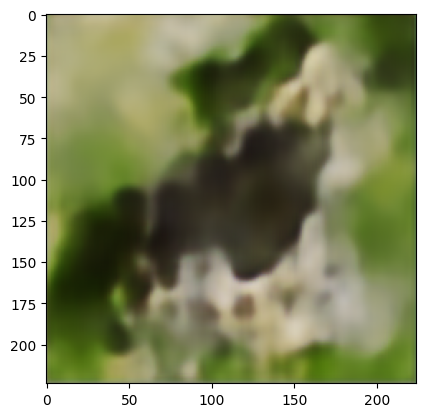

In [8]:
plt.imshow(generated[13])

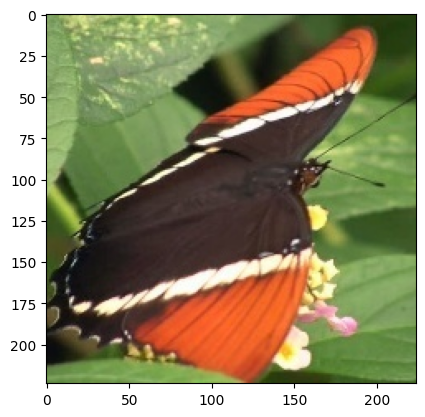

In [9]:
plt.imshow(images_test[13])